<img src="logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**

<hr />

# Flow lines and the material derivative in a steady flow field

In this notebook we will discuss:
* Path lines (particle trajectories)
* The material derivative
* Streamlines and the streamfunction

and observe them in a pre-computed steady flow field.

### Set up the module

In [1]:
using MAE150A

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/MAE150A/A9IAL.ji for MAE150A [a017625c-406c-46ee-99d6-0fac6062339e]
└ @ Base loading.jl:1240


In [2]:
pyplot()
initialize_environment()

### Load the flow from file

First, let us load the flow from a pre-computed CFD solution. This is the steady state flow past a NACA 4415 airfoil at 5 degrees angle of attack at Reynolds number 1000.

In [3]:
filename = "NACA4415_5deg.jld"
state, f, sys, body = load_ns_solution(filename);

Get the flow fields associated with the flow state: velocity (u), vorticity (ω), and streamfunction (ψ)

In [4]:
u, ω, ψ, Cp = get_flowfield(state,f,sys)

(Primal edges for a (nx = 504, ny = 208) cell grid of type Float64 data
  Internal u-faces: (nx = 504, ny = 207)
  Internal v-faces: (nx = 503, ny = 208), Dual nodes in a (nx = 504, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 504, ny = 208), Dual nodes in a (nx = 504, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 504, ny = 208), Primal nodes in a (nx = 504, ny = 208) cell grid of type Float64 data
  Number of Primal nodes: (nx = 503, ny = 207))

## Particle trajectories (i.e., pathlines)
First, let us discuss particle trajectories.

A particle moves at a velocity $\mathbf{V}(t)$ equal to the fluid velocity field, $\mathbf{u}(\mathbf{x},t)$, evaluated at the particle's location $\mathbf{r}(t)$. We can write this mathematically as

$$ \mathbf{V}(t) = \mathbf{u}(\mathbf{r}(t),t) $$

This means that the particle's trajectory, $\mathbf{r}(t)$, is determined by the equation

$$ \dfrac{\mathrm{d}\mathbf{r}}{\mathrm{d}t} = \mathbf{u}(\mathbf{r}(t),t) $$

If we integrate this equation over time, starting from some initial location $\mathbf{r}(0)$, then we get the trajectory of a single fluid particle.

If the velocity field is **steady**, then this equation simplifies a bit, because we lose the second argument ($t$) of $\mathbf{u}$, and we thus have only one unchanging velocity field to integrate.

If we want to look at trajectories of many particles, then we simply integrate this equation for each particle. Each particle corresponds to a different initial condition.

Let's compute the trajectories, $\mathbf{r}_p(t)$, of a few particles $p = 1,\ldots,n$, in this steady velocity field. We will release them from some places upstream of the airfoil and see where they go over a time interval.

In [5]:
#=
Initial locations of the particles. Each pair is the initial coordinates of a particle. You can (and should) play
around with these, add more particles, etc.
=#
pts = [ [-1,-0.5], [-1,0], [-1,0.25], [-1,-0.25] ]

#=
Time range over which to compute the trajectory (from t = 0 to t = Tmax). You might need to change this to
make the trajectories go far enough.
=#
Tmax = 5.0

#=
Time step size. This is set small to eliminate errors. Probably no reason to change it.
=#
Δt = 0.001

#=
Compute the trajectories.
=#
traj_array = compute_trajectory(u,sys,pts,Tmax,Δt);

Each entry in the output array `traj_array` contains a trajectory of a particle. For example, `traj_array[1]` contains the trajectory of particle 1, $\mathbf{r}_1(t)$.

Plot the trajectory, $\mathbf{r}_p(t)$, of each particle

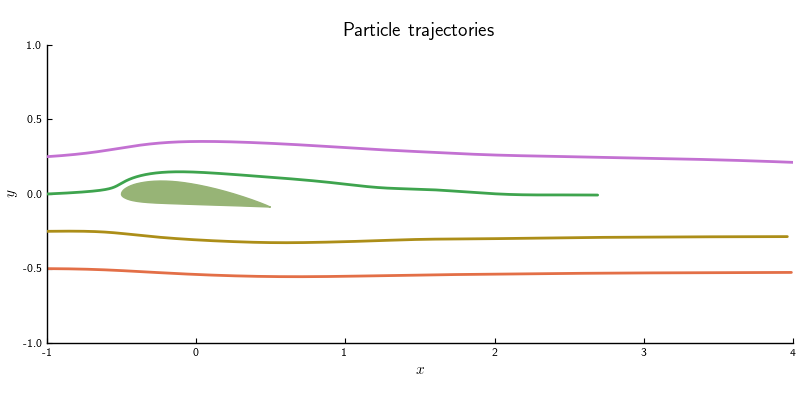

In [6]:
ps = plot(body,xlim=(-1,4),ylim=(-1,1),title="Particle trajectories",xlabel=L"x",ylabel=L"y") # plot the body
for traj in traj_array
    # plot the x, y coordinates of this particle's trajectory
    plot!(ps,traj[1,:],traj[2,:],linewidth=2)
end
plot(ps,size=(800,400))

## Particle acceleration and the material derivative of velocity
Now, let's develop some intuition for how the particle's velocity changes along its trajectory---i.e., the acceleration. From the particle's perspective (the Lagrangian perspective), this is simply

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} $$

But earlier, we equated the particle's velocity to the local fluid velocity field. If we take the time derivative of both sides of this equation, then, by the chain rule, we get

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} = \dfrac{\mathrm{d}\mathbf{r}}{\mathrm{d}t} \cdot \nabla \mathbf{u}(\mathbf{r}(t),t) + \dfrac{\partial \mathbf{u}}{\partial t} (\mathbf{r}(t),t).$$

Notice the appearance of the particle velocity ($\mathrm{d}\mathbf{r}/\mathrm{d}t$) on the right-hand side. We can replace this with the local fluid velocity. Let's also switch the order of the terms, as is conventional:

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} = \dfrac{\partial \mathbf{u}}{\partial t}(\mathbf{r}(t),t) + \mathbf{u} \cdot \nabla \mathbf{u}(\mathbf{r}(t),t).$$

The right hand side is called the material derivative of velocity, $D\mathbf{u}/Dt$. It contains two terms: a **convective acceleration** ($\mathbf{u}\cdot\nabla\mathbf{u}$), due to spatial changes of velocity along the particle's path, and an **unsteady term** ($\partial\mathbf{u}/\partial t$), due to time changes in the velocity field itself.

Like the fluid velocity, it is a field quantity (a function of space and time, independently of each other). Here, it is evaluated at the location of the particle:

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} = \dfrac{D \mathbf{u}}{D t} (\mathbf{r}(t),t)$$

### Material derivative in action
Let's explore this equality on our steady airfoil flow. In such a flow, the material derivative just contains the convective acceleration:

$$ \dfrac{D \mathbf{u}}{D t} = \mathbf{u}\cdot\nabla\mathbf{u}$$

So if we compute the convective acceleration field and then evaluate it along the particle's trajectory, this should be equal to the particle's acceleration. Let's try this.

#### Velocity along the trajectory
First, let us calculate the velocity along a particle's trajectory.

In [7]:
particle_number = 2
traj = traj_array[particle_number]

utraj,vtraj = field_along_trajectory(u,sys,traj);

Plot the velocity components as a function of the $x$ component of the trajectory. This allows us to see how these components change as the particle encounters the airfoil. We also plot the particle's trajectory for reference.

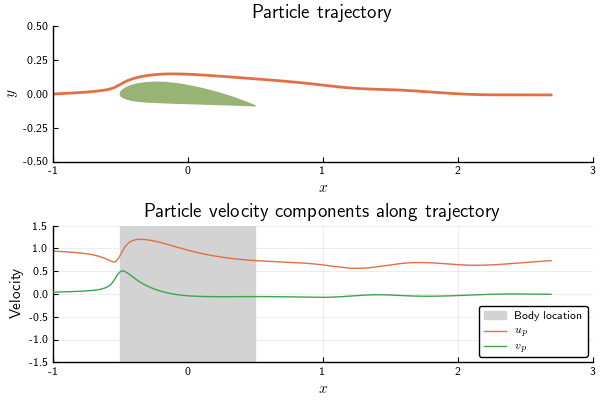

In [8]:
# Draw a rectangular box showing the range of x values where the airfoil lies
Xr = [minimum(body.x), maximum(body.x), maximum(body.x), minimum(body.x), minimum(body.x)]
Yr = [-20,-20,20,20,-20]
pv = plot(Xr,Yr,fillrange=0,fillcolor=:lightgray,linecolor=:lightgray,label="Body location",xlim=(-1,3),ylim=(-1.5,1.5))

# Plot the components of velocity
xtraj = traj[1,:]
ytraj = traj[2,:]
plot!(pv,xtraj,utraj,xlabel=L"x",label=L"u_p",title="Particle velocity components along trajectory")
plot!(pv,xtraj,vtraj,label=L"v_p",ylabel="Velocity")

ps = plot(body,xlim=(-1,3),ylim=(-0.5,0.5),title="Particle trajectory",xlabel=L"x",ylabel=L"y") # plot the body
plot!(ps,xtraj,ytraj,linewidth=2)
plot(ps,pv,layout=(2,1))

Notice how the particle's u component drops as it encounters the nose of the airfoil, while the v component gets larger as the particle moves toward the top of the airfoil.

The u component then **accelerates rapidly**---to a value even larger than the background flow speed---as it passes over the upper surface. (By the way: this aspect is essential for generating lift.)

Then both components get smaller as the particle passes over the rear part of the wing.

#### Rate of change of particle velocity
Let's evaluate the rate of change of this particle velocity

In [9]:
dudt_traj = ddt(utraj,Δt)
dvdt_traj = ddt(vtraj,Δt);

Now compute the convective acceleration field, $\mathbf{u}\cdot\nabla\mathbf{u}$, and evaluate it along the particle's trajectory.

In [10]:
# Calculates the convective acceleration field
ugradu = convective_acceleration(u,sys)

# Evaluate this field's components along the trajectory
ugradu_traj, ugradv_traj = field_along_trajectory(ugradu,sys,traj);

Plot the acceleration components. We will compare the particle's acceleration, $\mathrm{d}\mathbf{V}/\mathrm{d}t$, to the convective acceleration evaluated along the trajectory, $\mathbf{u}\cdot\nabla\mathbf{u}(\mathbf{r}(t))$. They should be equal:

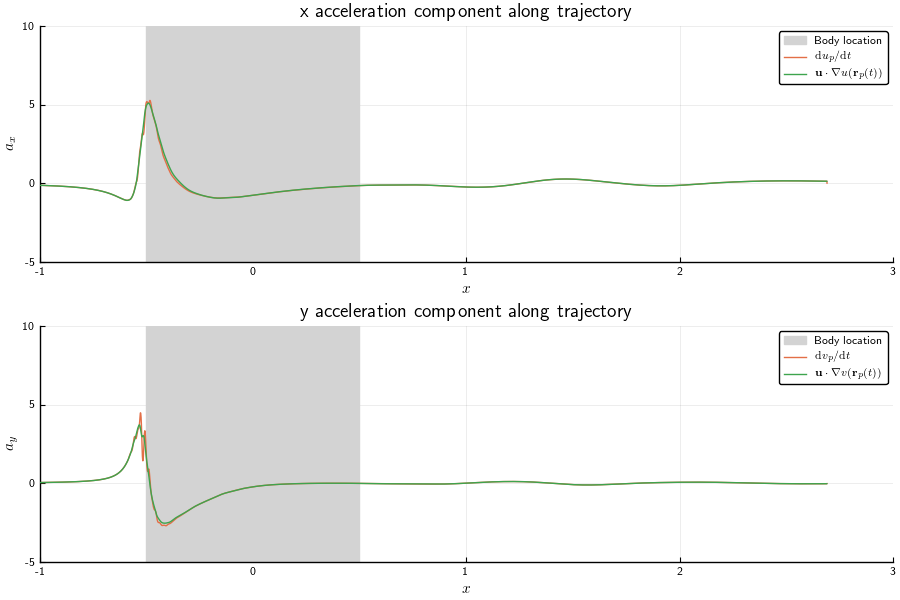

In [11]:
# Construct the plot

# Draw a rectangular box showing the range of x values where the airfoil lies
Xr = [minimum(body.x), maximum(body.x), maximum(body.x), minimum(body.x), minimum(body.x)]
Yr = [-20,-20,20,20,-20]

xtraj = traj[1,:]

# Plot the x component of particle acceleration and the x component of the convective acceleration
pv1 = plot(Xr,Yr,fillrange=0,fillcolor=:lightgray,linecolor=:lightgray,label="Body location",xlim=(-1,3),ylim=(-5,10))
plot!(pv1,xtraj,dudt_traj,xlabel=L"x",ylabel=L"a_x",label=L"\mathrm{d}u_p/\mathrm{d}t",title="x acceleration component along trajectory")
plot!(pv1,xtraj,ugradu_traj,label=L"\mathbf{u}\cdot\nabla u(\mathbf{r}_p(t))")

pv2 = plot(Xr,Yr,fillrange=0,fillcolor=:lightgray,linecolor=:lightgray,label="Body location",xlim=(-1,3),ylim=(-5,10))
# Plot the y component of particle acceleration and the y component of the convective acceleration
xtraj = traj[1,:]
plot!(pv2,xtraj,dvdt_traj,xlabel=L"x",ylabel=L"a_y",label=L"\mathrm{d}v_p/\mathrm{d}t",title="y acceleration component along trajectory")
plot!(pv2,xtraj,ugradv_traj,label=L"\mathbf{u}\cdot\nabla v(\mathbf{r}_p(t))")

plot(pv1,pv2,layout=(2,1),size=(900,600))

This confirms that these two ways of viewing the acceleration---the Lagrangian view from the particle's perspective, and the Eulerian calculation of an acceleration field---are, indeed, the same. There are some small differences, but these are due to numerical errors, not conceptual differences.